In [1]:
# Importing the model
from model.ctabgan import CTABGAN
# Importing the evaluation metrics 
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
# Importing standard libraries
import numpy as np
import pandas as pd
import glob

In [2]:
# Specifying the replication number 
num_exp = 1 
# Specifying the name of the dataset used 
dataset = "Adult" 
# Specifying the path of the dataset used 
real_path = "Real_Datasets/Adult.csv" 
# Specifying the root directory for storing generated data
fake_file_root = "Fake_Datasets" 

In [3]:
# Initializing the synthesizer object and specifying input parameters
# Notice: If you have continuous variable, you do not need to explicitly assign it. It will be treated like 
# that by default
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,  
                 categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                                        'relationship', 'race', 'gender', 'native-country', 'income'], 
                 log_columns = [],
                 mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]}, 
                 integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
                 problem_type= {"Classification": 'income'},
                 epochs = 150) 

# Fitting the synthesizer to the training dataset and generating synthetic data
for i in range(num_exp):
    synthesizer.fit()
    syn = synthesizer.generate_samples()
    syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [3:58:01<00:00, 95.21s/it]


Finished training in 14296.940654277802  seconds.


In [4]:
# Collecting the paths to all corresponding generated datasets for evaluation 
fake_paths = glob.glob(fake_file_root+"/"+dataset+"/"+"*")

In [5]:
# Specifying the list of classifiers to conduct ML utility evaluation
classifiers_list = ["lr","dt","rf","mlp","svm"]

# Storing and presenting the results as a dataframe
result_mat = get_utility_metrics(real_path,fake_paths,"MinMax",classifiers_list, test_ratio = 0.20)
result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

,Acc,AUC,F1_Score
lr,1.166957,0.012292,0.015533
dt,6.029276,0.036993,0.055934
rf,2.702426,0.025184,0.027291
mlp,1.709489,0.019828,0.051690
svm,0.143310,0.019660,-0.048958


In [6]:
# Specifying the categorical columns of the dataset used
adult_categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']

# Storing and presenting the results as a dataframe
stat_res_avg = []
for fake_path in fake_paths:
    stat_res = stat_sim(real_path,fake_path,adult_categorical)
    stat_res_avg.append(stat_res)

stat_columns = ["Average WD (Continuous Columns","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res_avg).mean(axis=0).reshape(1,3),columns=stat_columns)
stat_results

,Average WD (Continuous Columns,Average JSD (Categorical Columns),Correlation Distance
0,0.010366,0.082863,0.672686


In [7]:
# Storing and presenting the results as a dataframe
priv_res_avg = []
for fake_path in fake_paths:
    priv_res = privacy_metrics(real_path,fake_path)
    priv_res_avg.append(priv_res)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res_avg).mean(axis=0).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,0.372211,0.216545,0.261251,0.583181,0.442052,0.458546


In [8]:
# Storing generated data for future use if needed
syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

In [9]:
!pip install table_evaluator

In [10]:
from table_evaluator import TableEvaluator

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  int64  
 1   workclass       48842 non-null  float64
 2   fnlwgt          48842 non-null  int64  
 3   education       48842 non-null  float64
 4   marital-status  48842 non-null  float64
 5   occupation      48842 non-null  float64
 6   relationship    48842 non-null  float64
 7   race            48842 non-null  float64
 8   sex             48842 non-null  float64
 9   capital-gain    48842 non-null  int64  
 10  capital-loss    48842 non-null  int64  
 11  hours-per-week  48842 non-null  int64  
 12  native-country  48842 non-null  float64
 13  income          48842 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 5.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column 

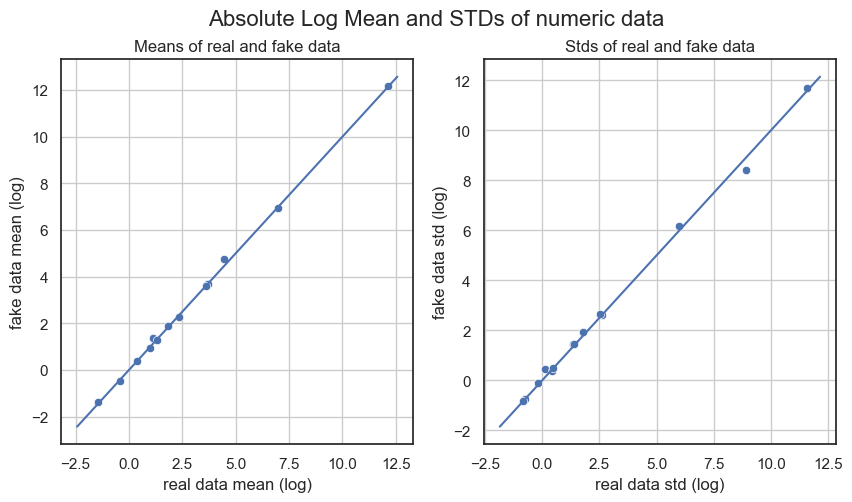

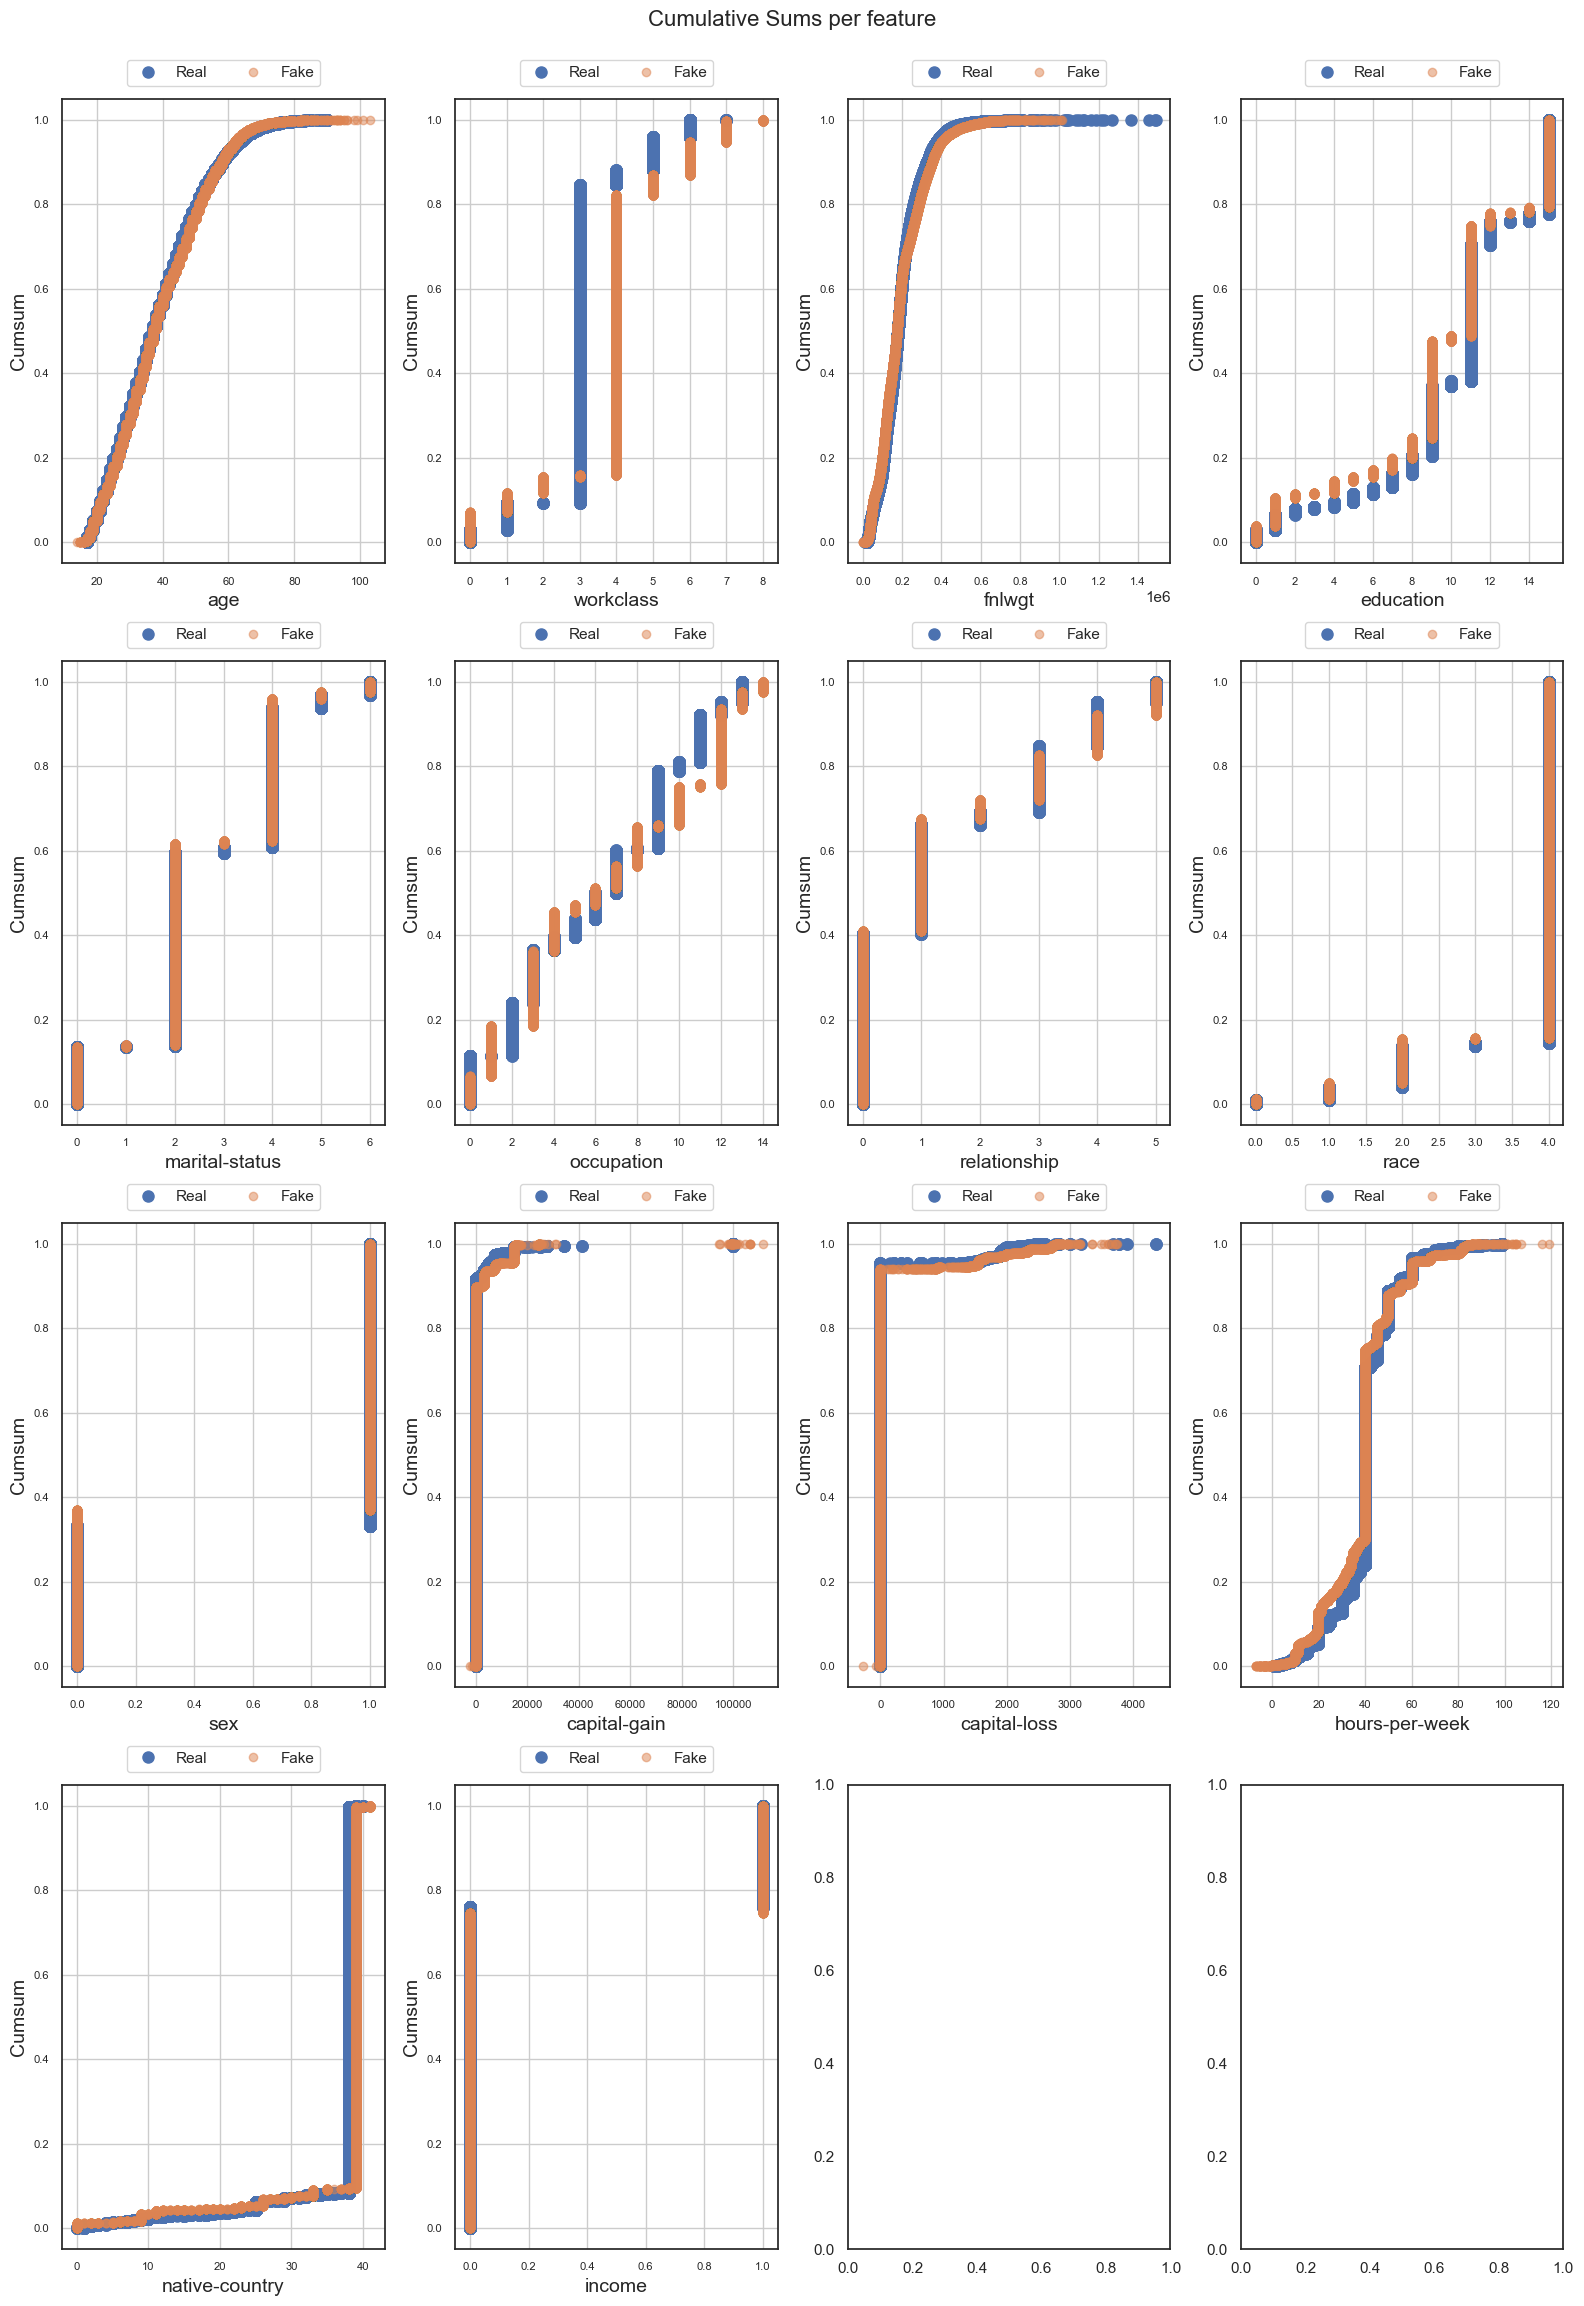

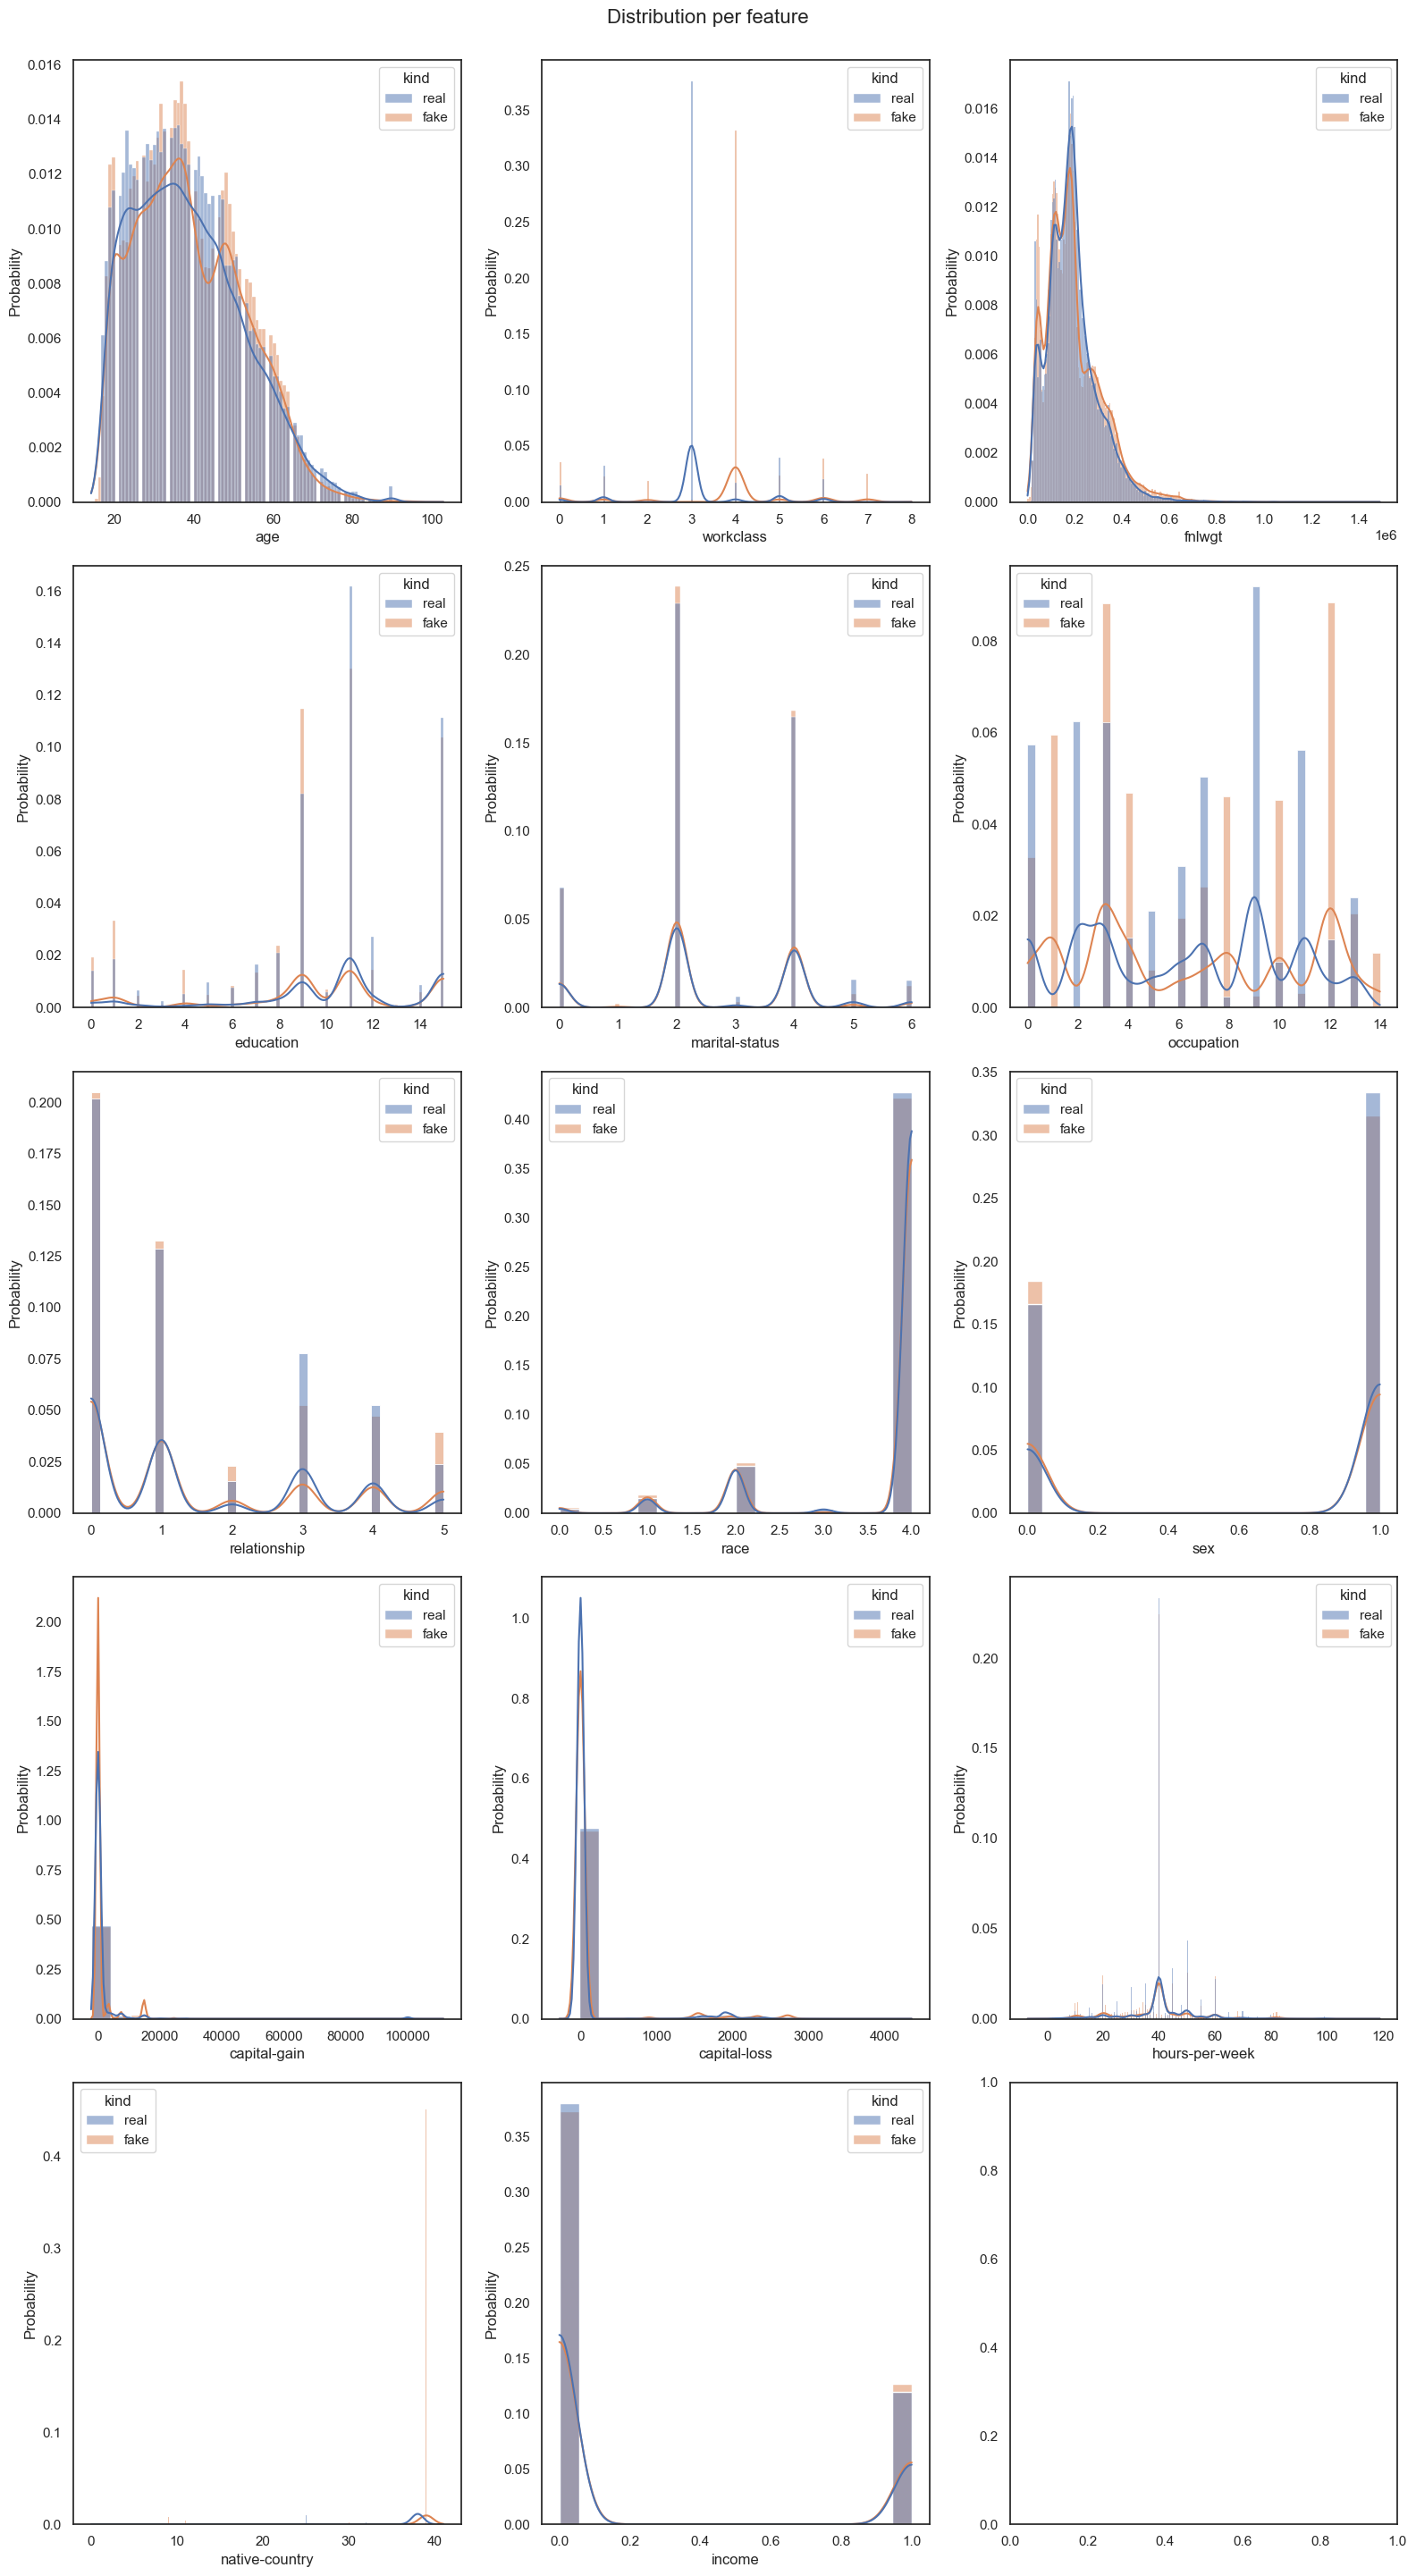

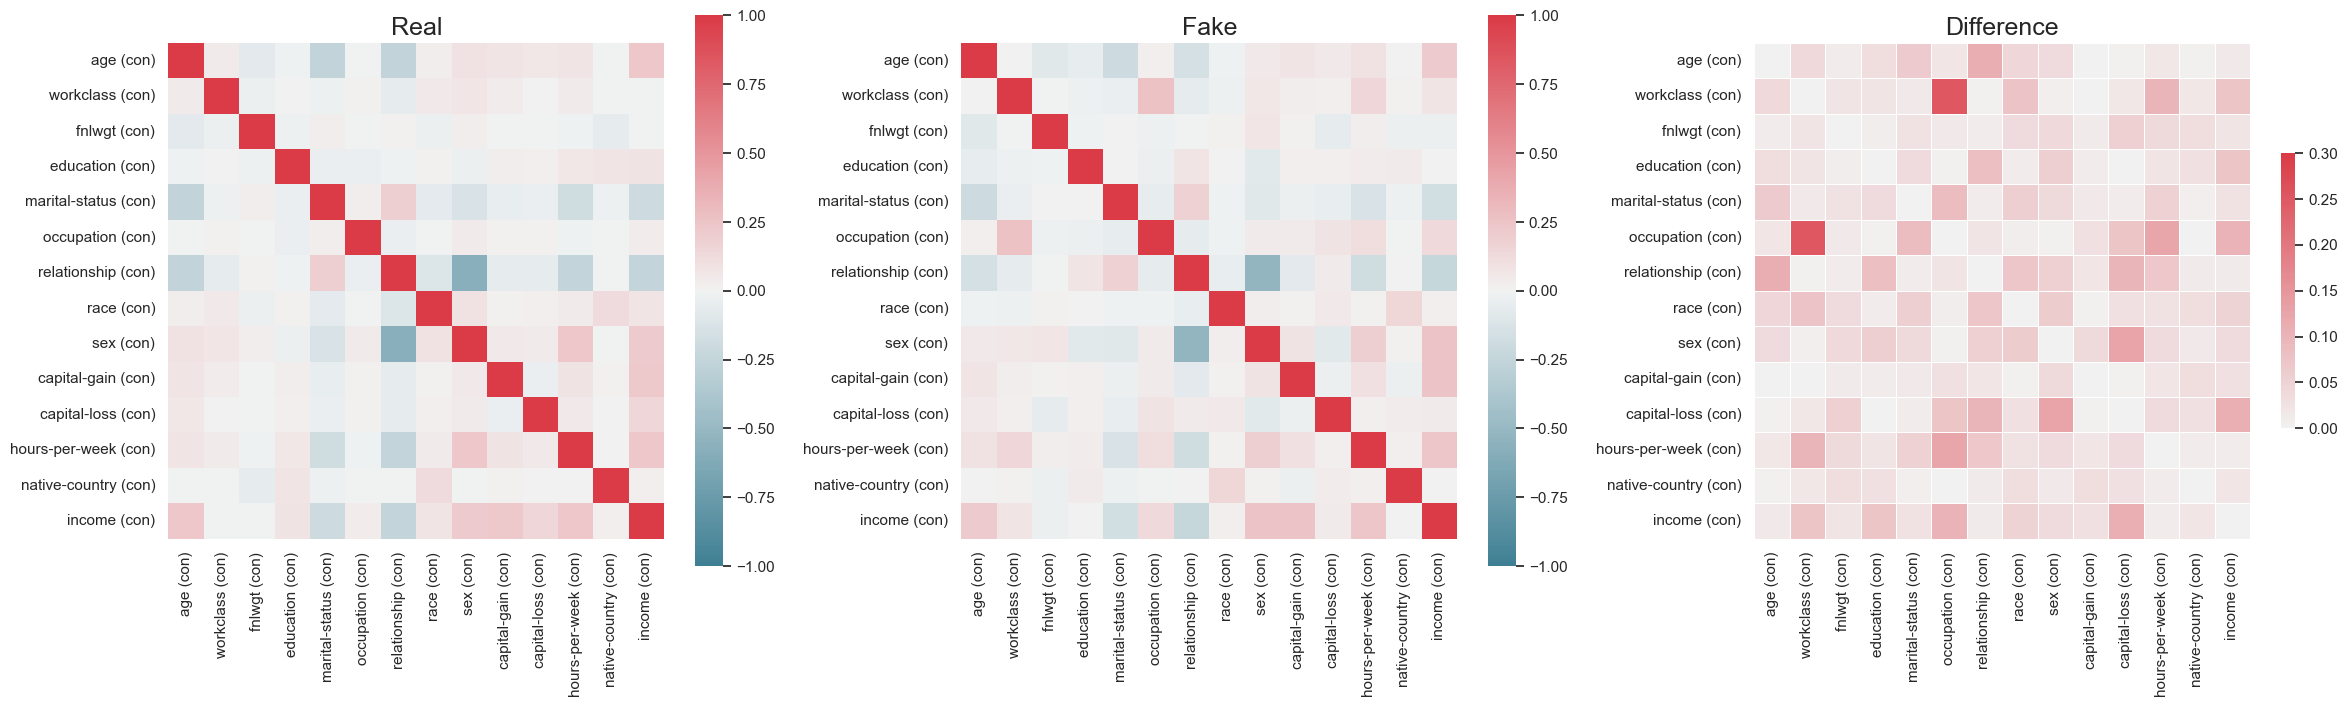

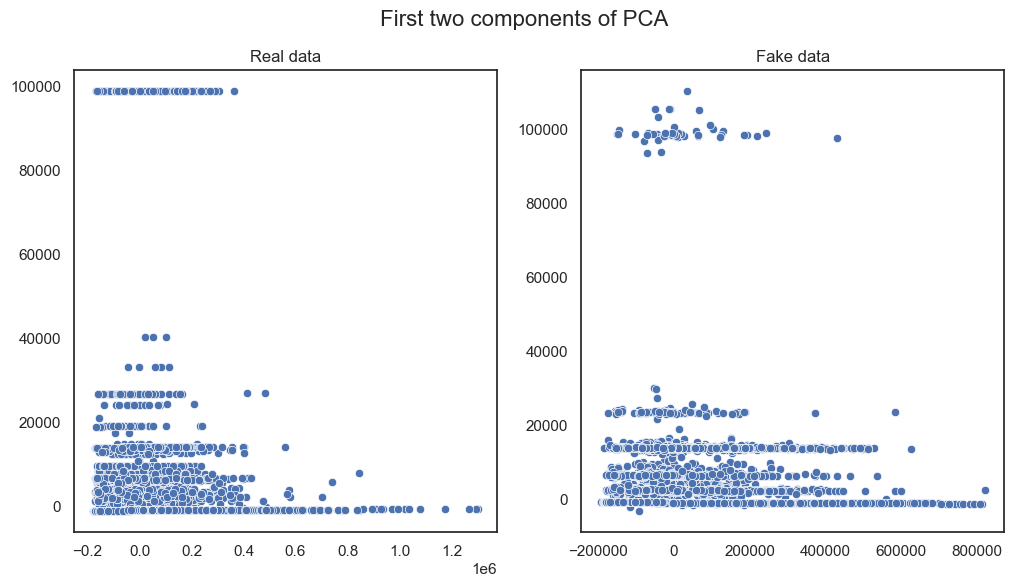

In [11]:
!pip install scipy==1.11.4
Real_Dataset = pd.read_csv('Real_Datasets/Adult/Adult.csv')
Fake_Dataset = pd.read_csv('Fake_Datasets/Adult/Adult_fake_0.csv')

Real_Dataset.head()
Real_Dataset.info()
Fake_Dataset.head()
Fake_Dataset.info()

print(Real_Dataset.shape, Fake_Dataset.shape)
table_evaluator = TableEvaluator(Real_Dataset, Fake_Dataset)

table_evaluator.visual_evaluation()